In [1]:
import os
import unicodedata
import string

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
from collections import Counter

In [5]:
#from pygoogletranslation import Translator

In [18]:
 
#################### EXTRACTION ####################

def extractionSeries(chemin_repertoire_racine):
    """
    Fonction qui va extraire les titres des différents séries, les titres des saisons et les sous titres des épisodes.
    
    param : chemin_repertoire_racine (string) -> chemin vers le repertoires racine qui contient.
    Un ensemble de sous repertoires et fichier texte qui correspond a une serie avec le titre de ces episodes.
    return : liste1[liste2[string]]  -> une liste1 ou chaque element de la liste1 correspond a une serie.
    La serie est une liste2[string] ou chaque element de cette liste correspond a un titre d'un episode de cette serie.
    """

    liste = []
    #Parcours des differentes series
    for serie in os.listdir(chemin_repertoire_racine) :
        chemin = chemin_repertoire_racine + "/" + serie
        serie = normaliseMot(listeFonctionNormaliseTitreSerie(),serie)
        #serie = filtreMot(listeFonctionNormaliseTitreSerie(),serie)
        liste.append( serie )
        #On va extraire les differents d'episodes de chaque serie
        liste += extractionDonnerSeries(chemin)
    
    #S'applique a la fin
    liste = filtreChaineVide(liste)
    return liste


def extractionDonnerSeries(chemin_sous_repertoire_racine) :
    """
    Fonction qui va extraire les titres des différents episodes des differentes saison d'une series.
    
    param : chemin_sous_repertoire_racine (string) -> chemin vers l'un des sous repertoires du dossier racine qui     contient un ensemble de sous repertoires et fichier texte qui correspond a une serie avec le titre de ces episodes.
    return : liste[string] -> liste de tous les titres des épisodes d'une série
    """
    mot = []

    for root, directories, files in os.walk(chemin_sous_repertoire_racine):  
       
        #Parcours l'ensemble des nom d'episode de serie 
        for file in files:
            
            file = normaliseMot(listeFonctionNormaliseTitreEpisodeSerie(),file)
            file = filtreMot(listeFonctionFiltreTitreEpisodeSerie(),file)
            mot.append(file)

        #Parcours l'ensemble des saision d'une serie
        for directorie in directories:

            chemin = chemin_sous_repertoire_racine + "/" + directorie
            #Parcours les nom d'episode d'une saison
            for donnerEpisode in os.listdir(chemin) :

                #lecture des sous titres d'un episode pour extraire les donnees
                listeFichier = extractionDonnerFichierEpisode(chemin + "/" + donnerEpisode)
                for donner in listeFichier :
                    mot.append(donner)
                
            directorie = normaliseMot(listeFonctionNormaliseTitreSerie(),directorie)
            #directorie = filtreMot(listeFonctionNormaliseTitreSerie(),directorie)
            mot.append(directorie)
         
    return mot

def extractionDonnerFichierEpisode(chemin) :
    """
    Fonction qui va extraire les sous titres d'un episodes d'une series.
    
    param : chemin (string) -> chemin vers le fichier qui contient les sous titres
    return : liste[string] -> liste de tous les sous titres d'un épisodes d'une série
    """
    fichier = open(chemin, "r",errors='ignore') #Pour eviter probleme encodage
    mot = []
    lignes = fichier.readlines()
    for str in lignes:
        str = normaliseMot(listeFonctionNormaliseDonnerEpisodeSerie(),str)
        str = filtreMot(listeFonctionFiltreDonnerEpisodeSerie(),str)
        mot.append(str)

    return mot 

In [7]:
#################### TRADUCTION ####################

def traduitDonner(str):
    """
    Fonction qui va traduire les titres des séries et épisodes en une seule langue.
    
    param : string -> chaine de caractere qui corresponds a un titres d'une serie ou d'un épisode.
    return : string -> chaine de caractere traduit en une unique langue.
    """
    trans = Translator()
    t = trans.translate(str,dest='en')
    return t.text

In [8]:
#################### NORMALISE ####################

def normaliseMot(listeFonction,str):
    """
    Fonction qui va normaliser une donner.
    Cette fonction va normaliser une donner en fonction de notre liste de fonction a normaliser
    
    param : liste[fonction(string)] : liste de fonction qu'on souhaite appliquer a un mot
    param : str : string -> chaine de caractere a normaliser
    return : liste[string] -> chaine de caractere normaliser.
    """
    for fonctionNormalise in listeFonction :
        str = fonctionNormalise(str)
    return str

def listeFonctionNormaliseTitreSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a un titre d'une serie
    return liste[fonction(string)]
    """
    return [supprimePremierChiffreSerie,supprimeAccent,minusculeString,supprimePonctuation]

def listeFonctionNormaliseSaisonSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a un titre d'une saison d'une serie
    return liste[fonction(string)]
    """
    return [supprimeAccent,minusculeString,supprimePonctuation]

def listeFonctionNormaliseTitreEpisodeSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a un titre d'un episode d'une serie
    return liste[fonction(string)]
    """
    return [supprimePremierChiffreEpisodeSerie,supprimeAccent,minusculeString,supprimeExtension,supprimePonctuation,radicalMot]

def listeFonctionNormaliseDonnerEpisodeSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a un titre d'un episode d'une serie
    return liste[fonction(string)]
    """
    return [supprimeAccent,minusculeString,supprimePonctuation,radicalMot]

def supprimeAccent(str):
    """
    Fonction qui supprime les accents de notre str.

    param : str : string ->  chaine de caractere qu'on souhaite supprimer les accents.
    return string : chaine de caractere sans accent
    """
    return unicodedata.normalize('NFKD', str).encode('ASCII', 'ignore').decode("utf-8")

def minusculeString(str):
    """
    Fonction qui rends en minuscule notre str.

    param : str : string ->  chaine de caractere qu'on souhaite mettre en minuscule.
    return string : chaine de caractere en minuscule
    """
    return str.lower()

def supprimeExtension(str):
    """
    Fonction qui supprime l'extension de notre str

    param : str : string -> chaine de caractere qu'on souhaite supprimer l'extension.
    return string : chaine de caractere sans extenstion
    """
    #appliquer cette fonction avant supprimePonctuation
    return "".join(str.split(".")[0:-1]) #slicing pour supprimer l'extension .txt


def supprimePonctuation(str):
    """
    Fonction qui supprime les caracteres de ponctuation de notre str

    param : str : string -> chaine de caractere qu'on souhaite supprimer la ponctuation.
    return : string -> chaine de caractere sans ponctuation.
    Attention la chaine de caractere pourra etre composer de plusieurs mot composer par des espaces.
    """
    for ponctuations in string.punctuation :
        str = str.replace(ponctuations, " ")
    return supprimeChaineVide(str.split(" "))

def supprimeChaineVide(liste):
    """
    Fonction qui supprime les chaines vide de notre liste.

    param : liste[string] -> liste composer de chaine de caractere qu'on souhaite filtrer les chaines
    de caractere vide.
    return : string : chaine de caractere composer des differentes string de notre liste separer par un 
    unique espace entre chaque mot.
    """
    temp = []
    for i in liste :
        if i != "":
            temp.append( i + " ")
    return "".join(temp)

def supprimePremierChiffreSerie(str):
    """
    Fonction qui supprime le premier chiffre de  notre str. 
    Cette fonction est particuliere a la normalisation des titres des series

    param : string -> chaine de caractere qu'on souhaite extraire la racine.
    return : string : radical de notre chaine de caractere donner en parametre. 
    """
    temp = []
    liste = str.split("___")
    for i in liste[1:] :
        temp.append(i + " ")
    return "".join(temp)

def supprimePremierChiffreEpisodeSerie(str):
    """
    Fonction qui supprime le premier chiffre de  notre str. 
    Cette fonction est particuliere a la normalisation des titres des series

    param : string -> chaine de caractere qu'on souhaite extraire la racine.
    return : string : radical de notre chaine de caractere donner en parametre. 
    """
    temp = []
    liste = str.split("__")
    for i in liste[1:] :
        temp.append(i + " ")
    return "".join(temp)

def radicalMot(str) :
    """
    Fonction qui radicalise notre str c'est a dire garde uniquement la racine du mot.

    param : string -> chaine de caractere qu'on souhaite extraire la racine.
    return : string : radical de notre chaine de caractere donner en parametre. 
    """
    stemmer = SnowballStemmer("english")
    return stemmer.stem(str)
    
def lemmatizeMot(str):
    """
    Fonction qui lemmatize notre str.

    param : string -> chaine de caractere qu'on souhaite lemmatize.
    return : string : radical de notre chaine de caractere donner en parametre. 
    """
    lemmatizer=WordNetLemmatizer()
    return lemmatizer.lemmatize(str)



In [9]:

#################### FILTRE ####################

def filtreMot(listeFonction,str) :
    """
    Fonction qui va filtrer les donner.
 
    param : liste[funtion(string)] -> liste de function a un argumnt de type string qui filtre une chaine de caractere 
    return : string -> chaine de caractere filtrer en fonction des differentes fontion de filtrage qu'on souhaite       appliquer.
    """
    for fonctionFiltre in listeFonction :
        str = fonctionFiltre(str)
        if str == " ":
            return " "
    return str

def listeFonctionFiltreTitreSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a un titre d'une serie
    return liste[fonction(string)]
    """
    return []

def listeFonctionFiltreSaisonSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a un titre d'une saison d'une serie
    return liste[fonction(string)]
    """
    return []

def listeFonctionFiltreTitreEpisodeSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a un titre d'un episode d'une serie
    return liste[fonction(string)]
    """
    return [filtreNombre,filtreMotInutile]

def listeFonctionFiltreDonnerEpisodeSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a un titre d'un episode d'une serie
    return liste[fonction(string)]
    """
    return [filtreNombre,filtreAntiSlashN]

def listeFonctionFiltreFinDonnerEpisodeSerie():
    """
    Retourne une liste de fonction qu'on souhaite appliquer a une donner une fois un premier netoyage realiser.
    (accent,ponctuation,radical,chiffre...)
    return liste[fonction(string)]
    """
    return [filtreStopWord]

def filtreNombre(str):
    """
    Fonction qui va filtrer les nombres de notre str donné en parametre.
 
    param : string-> string sur lesquel on souhaite filtre les nombres.
    return : string -> chaine de caractere filtrer.
    """
    for chiffre in ['0','1','2','3','4','5','6','7','8',"9"] :
        str = str.replace(chiffre, " ")
    return supprimeChaineVide(str.split(" "))

def filtreAntiSlashN(str):
    """
    Fonction qui va filtrer les nombres de notre str donné en parametre.
 
    param : string-> string sur lesquel on souhaite filtre les nombres.
    return : string -> chaine de caractere filtrer.
    """
    for lettre in ['\n'] :
        str = str.replace(lettre, " ")
    return supprimeChaineVide(str.split(" "))


def filtreMotInutile(str):
    #grap ou info
    if str == "grab" or str == "info" :
        return " "
    return str

def filtreStopWord(str):
    """
    Fonction qui verifie si notre str est un mot courant (pas interessant pour l'etude statistique).
    Elle retournera notre mot s'il n'est pas un stop word ou une chaine de caractere espace  dans le cas contraire (qui     sera enlever par la suite)

    param : string -> chaine de caractere qu'on souhaite tester s'il est stop word.
    return : string : notre str. 
    """
    if str in stopwords.words('english') :
        return " "
    return str


def filtreChaineVide(liste):
    """
    Fonction qui va filtrer les chaines de caractere vide.
 
    param : liste[string]-> string qui contient tous les mots a filtrer.
    return : liste[string] -> chaine de caractere filtrer.
    """
    resultat = []
    for i in liste :
        temp = i.split(" ")
        for k in temp :
            mot = filtreMot(listeFonctionFiltreFinDonnerEpisodeSerie(),k)
            if mot not in [""," "]:
                resultat.append(mot)
    
    return resultat
        



In [10]:

#################### AUTRE ####################

def calcule_frequence_serie(liste):
    dic = dict()
    
    for i in liste :
        if i in dic :
            dic[i] += 1
        else :
            dic[i] = 1
    
    return dic

In [51]:
#################### GRAPHE ####################

def graphe(liste):
    freq = Counter(liste)
    max = dict(freq.most_common(20))
    fig, ax = plt.subplots()
    ax = fig.add_axes(rect=[0,0,2,2])

    plt.bar(list(max.keys()), max.values(), color='g')
    plt.show()


In [22]:
### TEST
liste = extractionSeries("./test2")

In [14]:
os.listdir("./test3")

['1___Lost']

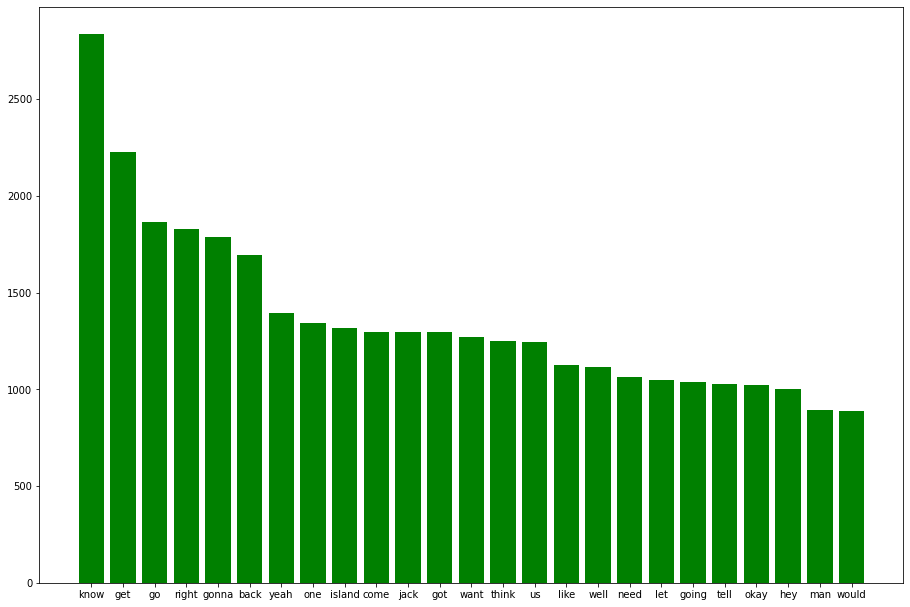

In [41]:
graphe(liste)

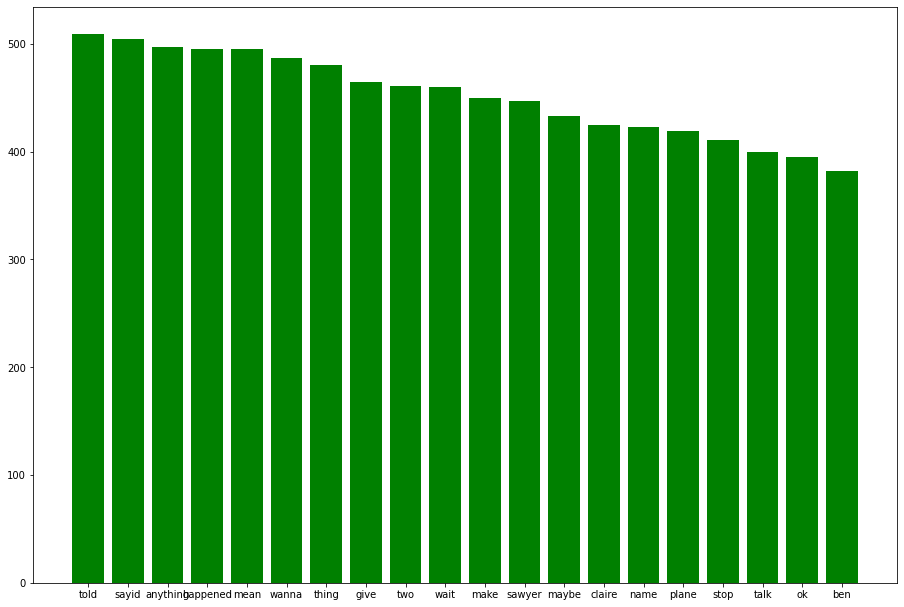

In [52]:
graphe(liste)